# ELMo Contextual Embeddings

In this notebook, we use contextual embeddings from ELMo to study semantic change of conversion.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import allennlp.commands.elmo
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import tqdm

import src.ud_corpus

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Read the CoNLL-U file

In [2]:
UD_FILE = "../data/en_ewt-ud-train.conllu"

ud = src.ud_corpus.UDCorpus(data_file_path=UD_FILE)
ud.data[:3]

[TokenList<Al, -, Zaman, :, American, forces, killed, Shaikh, Abdullah, al, -, Ani, ,, the, preacher, at, the, mosque, in, the, town, of, Qaim, ,, near, the, Syrian, border, .>,
 TokenList<[, This, killing, of, a, respected, cleric, will, be, causing, us, trouble, for, years, to, come, ., ]>,
 TokenList<DPA, :, Iraqi, authorities, announced, that, they, had, busted, up, 3, terrorist, cells, operating, in, Baghdad, .>]

## Run ELMo on the entire corpus

In [3]:
elmo = allennlp.commands.elmo.ElmoEmbedder(cuda_device=0)
data_as_tokens = [[t['form'] for t in token_list] for token_list in ud.data]

BATCH_SIZE = 64
elmo_embeddings = []
for ix in tqdm.tqdm(range(0, len(data_as_tokens), BATCH_SIZE)):
  batch = data_as_tokens[ix : ix+BATCH_SIZE]
  batch_embeddings = elmo.embed_batch(batch)
  # Only take embeddings from last ELMo layer
  batch_embeddings = [x[-1] for x in batch_embeddings]
  elmo_embeddings.extend(batch_embeddings)

100%|██████████| 196/196 [00:28<00:00,  5.55it/s]


## ELMo embeddings of instances of a fixed lemma

In [4]:
FIXED_LEMMA = "work"
noun_embeddings = []
verb_embeddings = []

for sentence_ix in range(len(ud.data)):
  token_list = ud.data[sentence_ix]
  embeddings = elmo_embeddings[sentence_ix]
  for i in range(len(token_list)):
    if token_list[i]['lemma'] == FIXED_LEMMA:
      if token_list[i]['upostag'] == 'NOUN':
        noun_embeddings.append(embeddings[i])
      elif token_list[i]['upostag'] == 'VERB':
        verb_embeddings.append(embeddings[i])

noun_embeddings = np.vstack(noun_embeddings)
verb_embeddings = np.vstack(verb_embeddings)
print("Noun instances:", noun_embeddings.shape[0])
print("Verb instances:", verb_embeddings.shape[0])

Noun instances: 118
Verb instances: 223


## Apply PCA and plot

In [5]:
pca = sklearn.decomposition.PCA(n_components=2)
all_embeddings = pca.fit_transform(np.vstack([noun_embeddings, verb_embeddings]))
all_embeddings_df = pd.DataFrame({'x0': all_embeddings[:,0], 'x1': all_embeddings[:,1]})
all_embeddings_df['pos'] = ['noun'] * len(noun_embeddings) + ['verb'] * len(verb_embeddings)

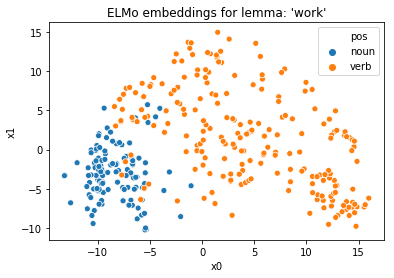

In [6]:
plot = sns.scatterplot(data=all_embeddings_df, x='x0', y='x1', hue='pos')
plot.set(title="ELMo embeddings for lemma: '%s'" % FIXED_LEMMA)
plt.show()